## Setup

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
import os
import cv2

In [14]:
import cv2
import os
import numpy as np


folder_path ="../test_video_list"
sufflx = "mp4"

video_name_list = os.listdir(folder_path)
print("folder_path : "+folder_path)
print("video_list : "+ str(video_list))



for video_name in video_name_list:
    print("path_of_video : " +folder_path+'/'+video_name)
    video = cv2.VideoCapture(folder_path+'/'+video_name)
    index = 1

    if os.path.isdir(video_name.replace("."+sufflx,""))==False:
        os.mkdir("../images/"+video_name.replace("."+sufflx,""))
    if video.isOpened():
        while True:
            ret, img_color = video.read()
            if ret:
                img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
                cv2.imwrite("../images/"+video_name.replace("."+sufflx,"")+"/"+str(index)+".jpg",img_gray)
                cv2.waitKey(33) # 30fps per 1 sec
                index=index+1
            else:
                break
    else:
        print("파일읽기 불가능")
        video_list = []

cv2.destroyAllWindows()

folder_path : ../test_video_list
video_list : ['1.mp4', '2.mp4', '3.mp4', '4.mp4']
path_of_video : ../test_video_list/1.mp4
path_of_video : ../test_video_list/2.mp4
path_of_video : ../test_video_list/3.mp4
path_of_video : ../test_video_list/4.mp4


In [31]:
import shutil

folder_path ="../images/"
target_folder_path = "../images/15fps_image_list/"
created_folder_name_list = ['shaking_middle_finger','shaking_thumb','stopped_middle_finger','stopped_thumb']


for folder_name in created_folder_name_list:
    image_file_list = os.listdir(os.path.join(folder_path,folder_name))
    os.mkdir(target_folder_path + folder_name)
    folder_idx = 1
    for i in range(len(image_file_list)):
        if i % 15 == 0: 
            folder_idx += 1
            os.mkdir(target_folder_path + folder_name + "/" + str(folder_idx-1)+"/")
        shutil.copyfile(folder_path + folder_name + "/" + image_file_list[i], target_folder_path + folder_name + "/" + str(folder_idx-1)+"/" + image_file_list[i])

In [74]:
path = "../images/15fps_image_list/"




def extract_data_and_load_for_test(path):
    row_size =60
    col_size = 160
    classes1 = ["shaking_middle_finger", "stopped_middle_finger"]
    classes2 = ["shaking_thumb", "stopped_thumb"]
    x1 = []
    x1_tmp = []
    x2 = []
    y = []
    frame_list = []
    proceed = 1

    for class1 in classes1:
        for class2 in classes2:
            class1_folder_list =os.listdir(path+class1)
            class2_folder_list =os.listdir(path+class2)
            for class1_folder in class1_folder_list:
                for class2_folder in class2_folder_list:
                    class1_imgs = os.listdir(path + class1 + "/" +class1_folder)
                    class2_imgs = os.listdir(path + class2 + "/" +class2_folder)
                    for img in class1_imgs:
                        image = cv2.imread(path + class1 + "/" +class1_folder+"/"+img,cv2.IMREAD_GRAYSCALE)
                        image = cv2.resize(image,dsize=(col_size,row_size),interpolation=cv2.INTER_AREA)
                        frame_list.append(image)
                    x1.append(frame_list)
                    x1_tmp = np.array(x1,dtype=object)
                    frame_list = []
                    
                    
                    for img in class2_imgs:
                        image = cv2.imread(path + class2 + "/" +class2_folder+"/"+img,cv2.IMREAD_GRAYSCALE)
                        image = cv2.resize(image,dsize=(col_size,row_size),interpolation=cv2.INTER_AREA)
                        frame_list.append(image)
                    x2.append(frame_list)
                    frame_list = []
                    
                    if class1 == "shaking_middle_finger" and class2 == "shaking_thumb":
                        y.append([1,0,0]) # shaking hand
                    if class1 == "shaking_middle_finger" and class2 == "stopped_thumb":
                        y.append([0,1,0]) # aside shaking hand
                    if class1 == "stopped_middle_finger" and class2 == "shaking_thumb":
                        y.append([0,1,0]) # aside shaking hand
                    if class1 == "stopped_middle_finger" and class2 == "stopped_thumb":
                        y.append([0,0,1]) # stopped hand
#                     print(proceed,end="\r")
                    print(x1_tmp.shape,end="\r")
                    proceed += 1
    return x1_tmp,np.array(x2, dtype=object),np.array(y, dtype=object)
                    

    


 


In [75]:
x1, x2, y = extract_data_and_load_for_test(path)  
print(x1.shape,x2.shape)
print(y.shape)

# print(x1[0])
# print(y.shape)

(400, 15, 60, 160) (400, 15, 60, 160)
(400, 3)


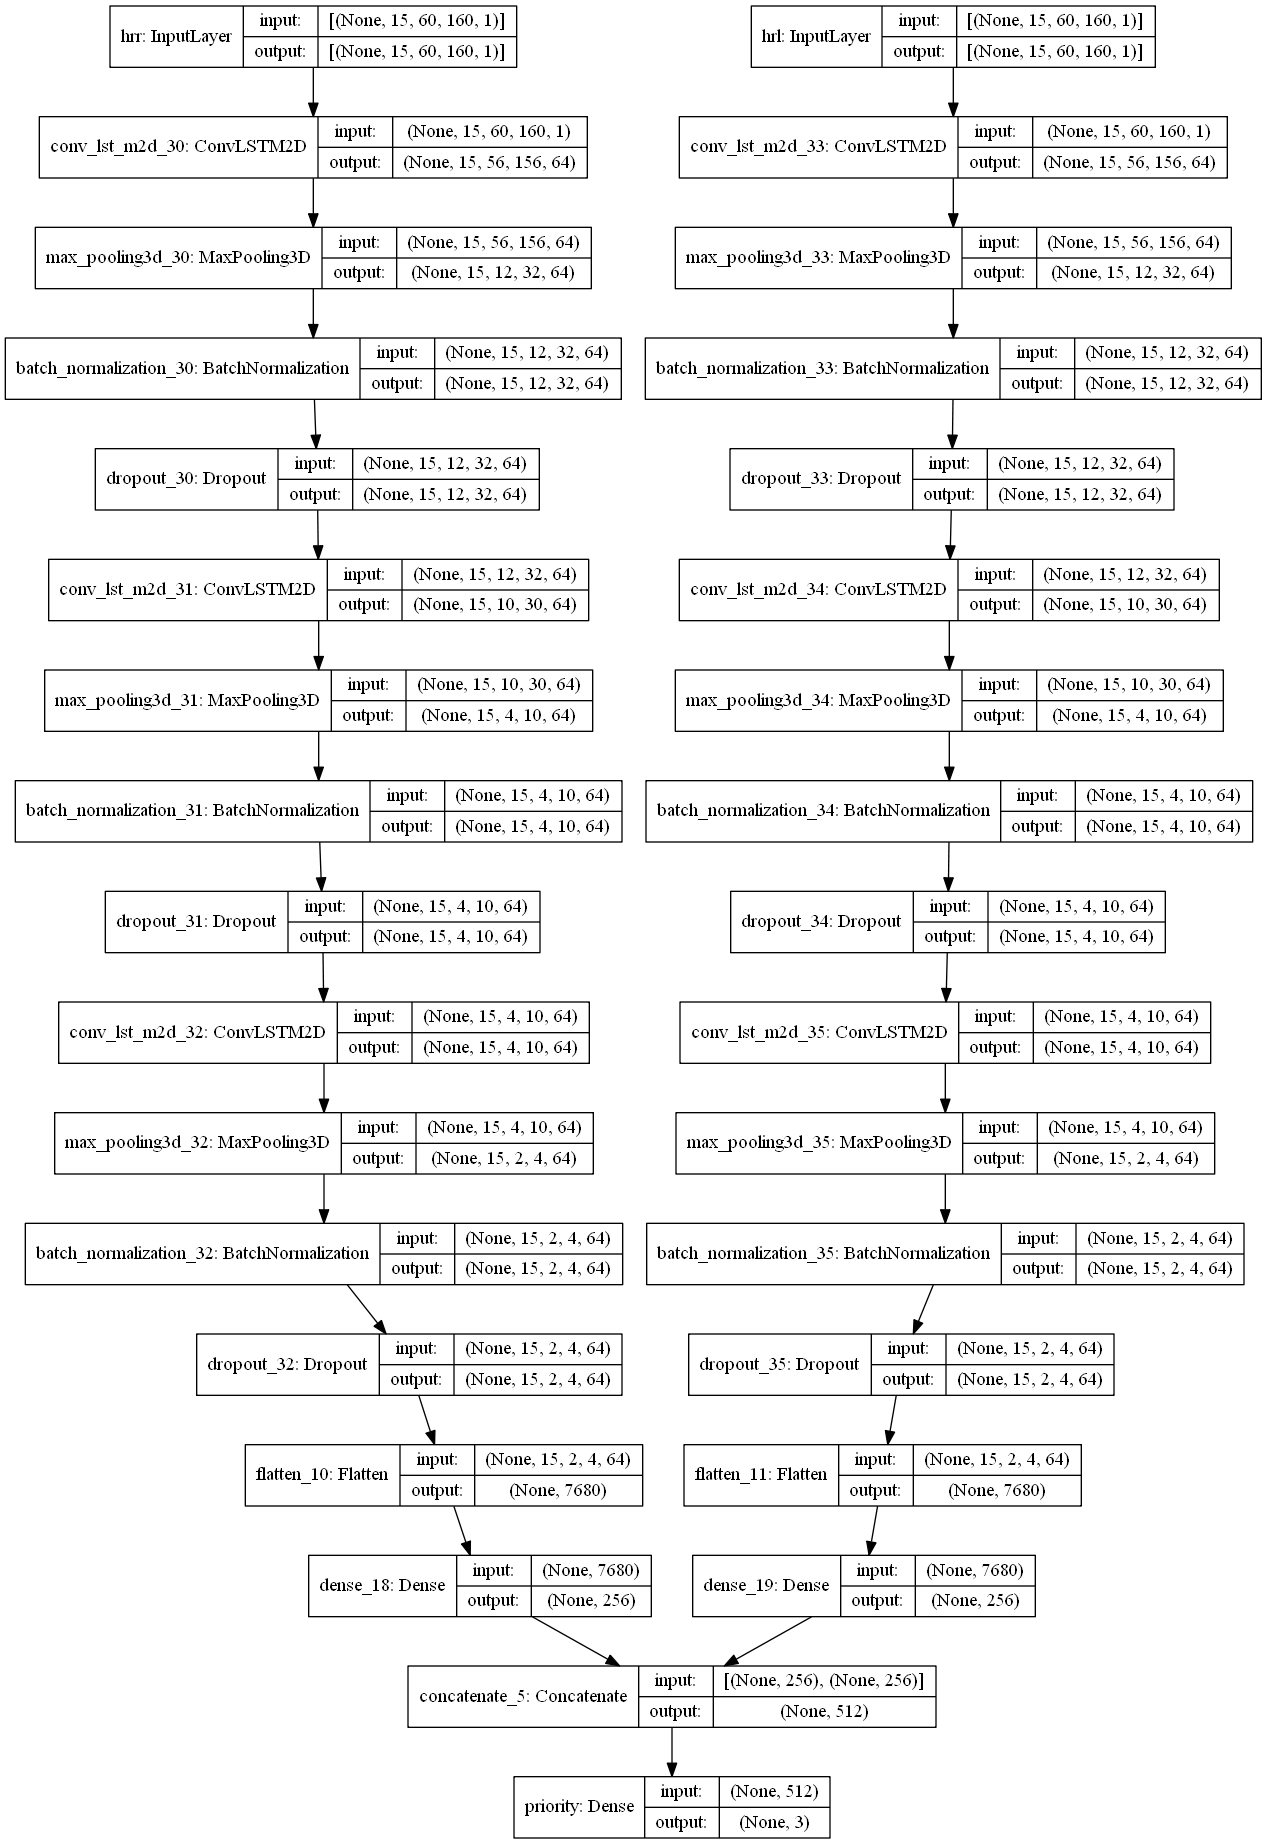

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model

def get_model(inp):
    x = layers.ConvLSTM2D(filters=64,kernel_size=(5, 5),return_sequences=True,activation="tanh")(inp)
    x = layers.MaxPooling3D(pool_size = (1,5,5),padding ='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.ConvLSTM2D(filters=64,kernel_size=(3, 3),return_sequences=True,activation="tanh")(x)
    x = layers.MaxPooling3D(pool_size = (1,3,3),padding ='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.ConvLSTM2D(filters=64,kernel_size=(1, 1),return_sequences=True,activation="tanh")(x)
    x = layers.MaxPooling3D(pool_size = (1,3,3),padding ='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256,activation = "relu")(x)
    return x
hrr_input = keras.Input(shape=(15,60,160,1),name="hrr")
hrl_input = keras.Input(shape=(15,60,160,1),name="hrl")

hrr_model = get_model(hrr_input)
hrl_model = get_model(hrl_input)



x = layers.concatenate([hrr_model,hrl_model])
priority_pred = layers.Dense(3,activation = "softmax", name="priority")(x)

model = Model(
    inputs = [hrr_input,hrl_input],
    outputs = [priority_pred],
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    loss_weights=0.2,
)

keras.utils.plot_model(model,"my_first_model.png", show_shapes=True)